In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import muon as mu

import cellij

/Users/martin/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pyro
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x15b480a50>


In [5]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [6]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 100
n_features = [200, 200, 200]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 2
n_partially_shared_factors = 15
n_private_factors = 3

# optional: number of covariates to generate
n_covariates = 2

In [7]:
dg = cellij.core.synthetic.DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# introduce missing values in the data
dg.generate_missingness(
    random_fraction=0.1, 
    n_incomplete_samples=10, 
    n_incomplete_features=50, 
    missing_fraction_incomplete_features=0.5, 
    seed=seed
    )

# center data
dg.normalize(with_std=False)

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [8]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

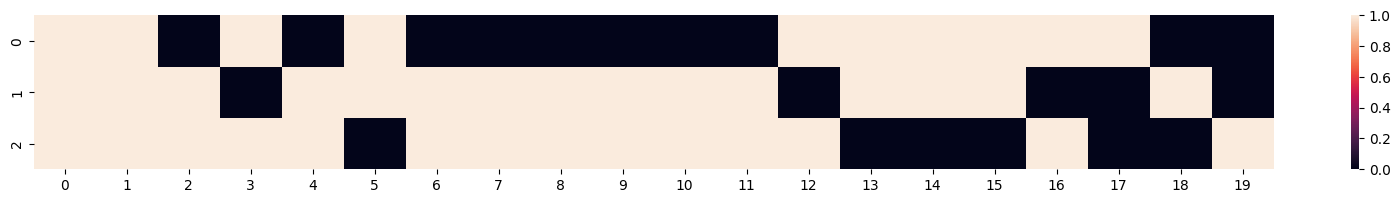

In [9]:
# view factor relationships
lined_heatmap(dg.feature_group_factor_mask)

<Axes: >

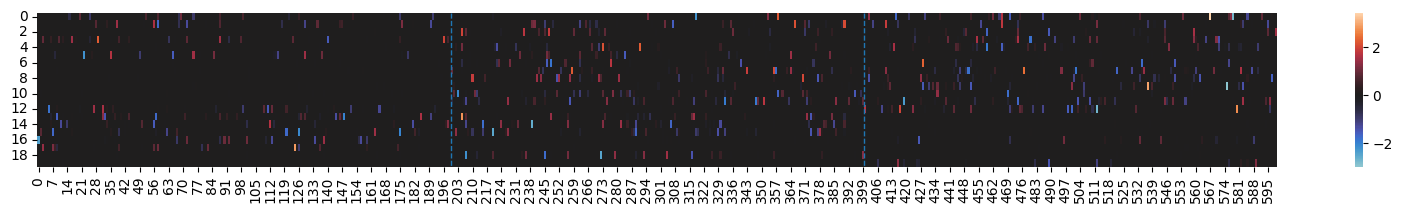

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)

<Axes: >

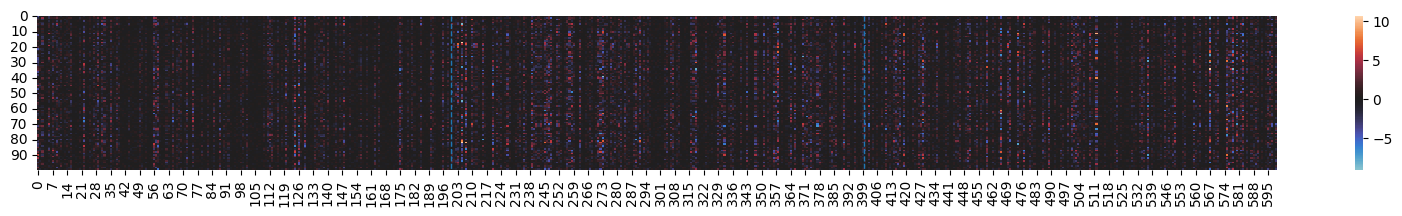

In [11]:
# observed data
lined_heatmap(dg.y, vlines=vlines, center=0)

<Axes: >

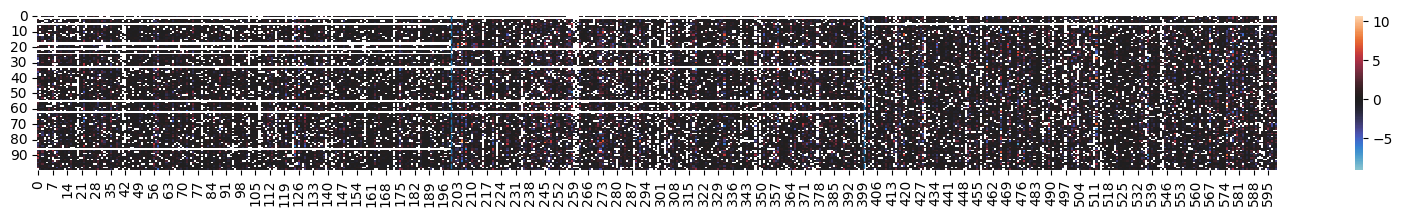

In [12]:
# missing data
lined_heatmap(dg.missing_y, vlines=vlines, center=0)

In [13]:
mdata = mu.MuData({f"view_{m}": ad.AnnData(pd.DataFrame(dg.ys[m], index=[str(i) for i in range(n_samples)], columns=[str(j) for j in range(feature_offsets[m],feature_offsets[m+1])])) for m in range(n_views)})
mdata

MuData object with n_obs × n_vars = 100 × 600
  3 modalities
    view_0:	100 x 200
    view_1:	100 x 200
    view_2:	100 x 200

In [14]:
mdata = cellij._data.Importer().load_CLL()
mdata["mrna"]

AnnData object with n_obs × n_vars = 136 × 5000

In [31]:
model1 = cellij.core.models.MOFA(n_factors=50, sparsity_prior="Lasso")
model1.add_data(data=mdata, na_strategy="knn_by_obs")

model1.fit(likelihood="Normal",  epochs=10000, verbose_epochs=500)

Epoch      0:     7560944.66
Epoch    500:     4309400.44
Epoch   1000:     3718823.86
Epoch   1500:     3502933.66
Epoch   2000:     3405194.19
Epoch   2500:     3351589.87
Epoch   3000:     3318878.73
Epoch   3500:     3298109.09
Epoch   4000:     3283894.39
Epoch   4500:     3273720.97
Epoch   5000:     3267651.03
Epoch   5500:     3260434.65
Epoch   6000:     3257809.07
Epoch   6500:     3254120.24
Epoch   7000:     3251963.32
Epoch   7500:     3249804.63
Epoch   8000:     3248244.29
Epoch   8500:     3245237.72
Epoch   9000:     3244718.45
Epoch   9500:     3243847.69
Epoch  10000:     3241932.74


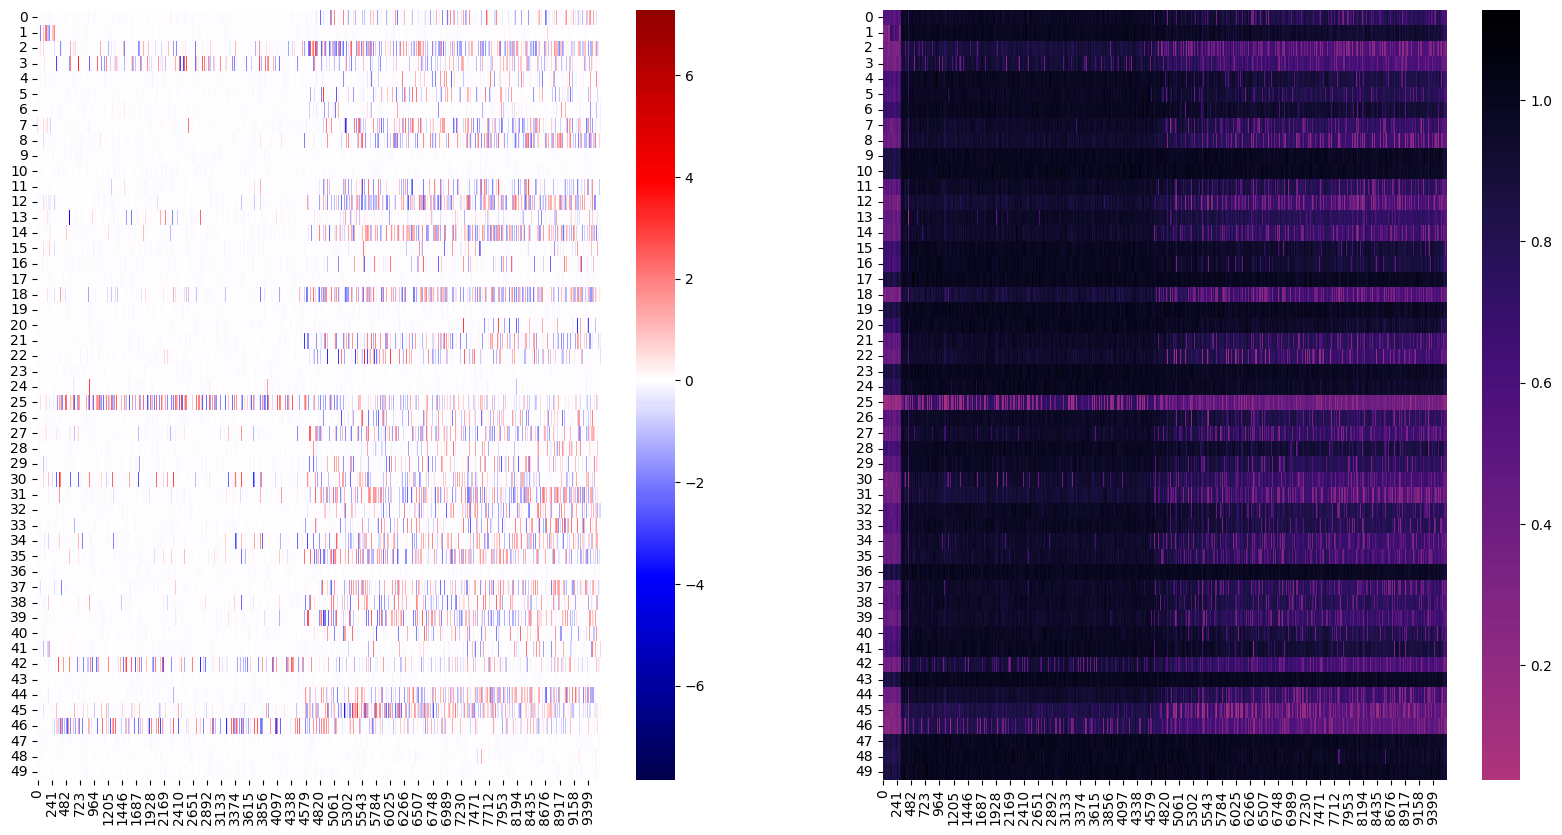

In [51]:
w_loc = pyro.get_param_store().get_param("FactorModel._guide.locs.w").detach().cpu().numpy()
w_scale = pyro.get_param_store().get_param("FactorModel._guide.scales.w").detach().cpu().numpy()
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(w_loc, center=0, ax=ax[0], cmap="seismic")
sns.heatmap(w_scale, center=0, ax=ax[1], cmap="magma_r")
plt.show()